In [1]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


tsai       : 0.2.15
fastai     : 2.2.5
fastcore   : 1.3.19
torch      : 1.7.1+cu101


# 0. load data

In [2]:
input_fn = 'F:\\Github\\kaggle drought\\data_ndarray.npz'

In [3]:
data = np.load(open(input_fn, 'rb'))

In [4]:
X_train = data['X_train']

In [5]:
X_train.shape

(118024, 90, 18)

In [6]:
print(np.mean(X_train.flatten()))

1.1619668e-07


In [7]:
print(np.std(X_train.flatten()))

1.0000005


In [8]:
X_valid = data['X_valid']

In [9]:
X_test = data['X_test']

In [10]:
y_train = data['y_train']
y_train = np.array([int(i) for i in y_train])

In [11]:
y_valid = data['y_valid']
y_valid = np.array([int(i) for i in y_valid])

In [12]:
y_test = data['y_test']
y_test = np.array([int(i) for i in y_test])

We need to exchange two axes：
* **number of samples**
* **number of features** (aka variables, dimensions, channels)
* **number of steps** (or length, time steps, sequence steps)

In [13]:
X_train = X_train.transpose(0, 2, 1)
X_train.shape

(118024, 18, 90)

In [14]:
X_valid = X_valid.transpose(0, 2, 1)
X_valid.shape

(20721, 18, 90)

In [15]:
X_test = X_test.transpose(0, 2, 1)
X_test.shape

(102430, 18, 90)

We already have the split:

In [16]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [17]:
X.shape

(138745, 18, 90)

In [18]:
y.shape

(138745,)

In [19]:
splits

((#118024) [0,1,2,3,4,5,6,7,8,9...],
 (#20721) [118024,118025,118026,118027,118028,118029,118030,118031,118032,118033...])

In [20]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#138745) [(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32))...]

# 1. Model and Hyperparameter Tuning

In [21]:
import hyperopt
print(hyperopt.__version__)

0.2.5


In [22]:
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp

In [23]:
search_space = {
    'batch_size': hp.choice('bs', [256, 512, 1024]),
    'time_steps': hp.choice('ts', [30, 60, 90]),  # lookback window size
    "lr": hp.choice('lr', [0.1, 0.01, 0.001, 0.0001]),
    "epochs": hp.choice('epochs', [10, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    # model parameters
    "nf": hp.choice('nf', [8, 16, 32])
}

In [24]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x207ba018088>,
 'time_steps': <hyperopt.pyll.base.Apply at 0x207ba0186c8>,
 'lr': <hyperopt.pyll.base.Apply at 0x207ba018e08>,
 'epochs': <hyperopt.pyll.base.Apply at 0x207ba01c448>,
 'patience': <hyperopt.pyll.base.Apply at 0x207ba01c9c8>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x207ba01cfc8>,
 'nf': <hyperopt.pyll.base.Apply at 0x207ba016648>}

In [25]:
X.shape

(138745, 18, 90)

In [26]:
time_steps = 30

In [27]:
X[:, :, -time_steps:].shape

(138745, 18, 30)

In [28]:
X_test[:, :, -time_steps:].shape

(102430, 18, 30)

In [29]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [30]:
import time
from fastai.callback.tracker import EarlyStoppingCallback

In [31]:
import gc

In [32]:
# clear memory 
gc.collect()

192

In [33]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:",params)
        batch_size = params["batch_size"]
        time_steps = params["time_steps"]
    
        # Create data loader
        tfms  = [None, [Categorize()]]
        dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = XceptionTime
        k = {
            'nf': params['nf']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
    
        # Training the model
        learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
    
        vals = learn.recorder.values[-1]
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Search the parameters:

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'lr': 0.0001, 'nf': 8, 'optimizer': <function Adam at 0x00000207F9E9D438>, 'patience': 10, 'time_steps': 90}
XceptionTime                                                                                                           
  0%|                                                                           | 0/30 [00:30<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,accuracy,time
0,1.753341,1.781614,0.278124,00:14
1,1.691107,1.731541,0.451137,00:10
2,1.649827,1.692913,0.521307,00:10
3,1.616354,1.671356,0.542397,00:10
4,1.594572,1.636832,0.552145,00:10
5,1.570988,1.604904,0.556103,00:10
6,1.549435,1.573814,0.555813,00:10
7,1.525950,1.547949,0.557743,00:10
8,1.499897,1.534201,0.559626,00:10
9,1.476141,1.512340,0.561845,00:10


No improvement since epoch 51: early stopping                                                                          
  0%|                                                                           | 0/30 [11:21<?, ?trial/s, best loss=?]

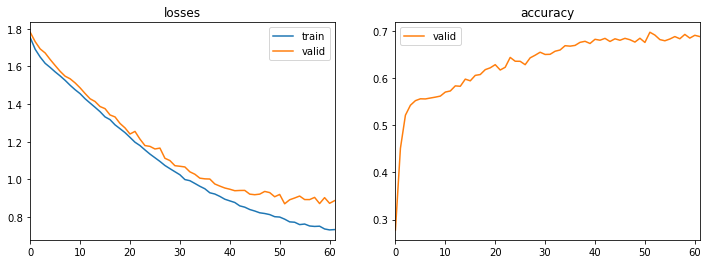

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 10, 'lr': 0.1, 'nf': 16, 'optimizer': <function RMSProp at 0x00000207F9E9D1F8>, 'patience': 5, 'time_steps': 30}
XceptionTime                                                                                                           
  3%|█▌                                            | 1/30 [11:49<5:29:22, 681.46s/trial, best loss: 0.8862910866737366]

epoch,train_loss,valid_loss,accuracy,time
0,1.015525,1.214919,0.634477,00:09
1,1.000909,0.967939,0.653106,00:09
2,1.007867,1.724408,0.137879,00:09
3,1.149271,2735426.750000,0.048598,00:09
4,1.140278,1353212.750000,0.048598,00:09
5,1.143742,640570.625000,0.036678,00:09
6,1.140859,5198419.000000,0.048598,00:09


No improvement since epoch 1: early stopping                                                                           
  3%|█▌                                            | 1/30 [12:55<5:29:22, 681.46s/trial, best loss: 0.8862910866737366]

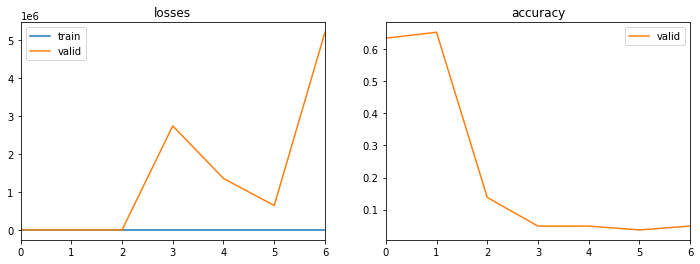

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'lr': 0.01, 'nf': 32, 'optimizer': <function Adam at 0x00000207F9E9D438>, 'patience': 5, 'time_steps': 30}
XceptionTime                                                                                                           
  7%|███                                           | 2/30 [13:23<3:55:50, 505.37s/trial, best loss: 0.8862910866737366]

epoch,train_loss,valid_loss,accuracy,time
0,1.371398,1.379747,0.573476,00:20
1,1.053185,1.015843,0.661792,00:18
2,0.895567,0.974915,0.672361,00:18
3,0.796439,1.036808,0.629458,00:18
4,0.717948,1.035566,0.656773,00:18
5,0.638063,1.211119,0.649148,00:18
6,0.553539,1.203503,0.638000,00:18
7,0.447222,1.263843,0.637952,00:18


No improvement since epoch 2: early stopping                                                                           
  7%|███                                           | 2/30 [15:54<3:55:50, 505.37s/trial, best loss: 0.8862910866737366]

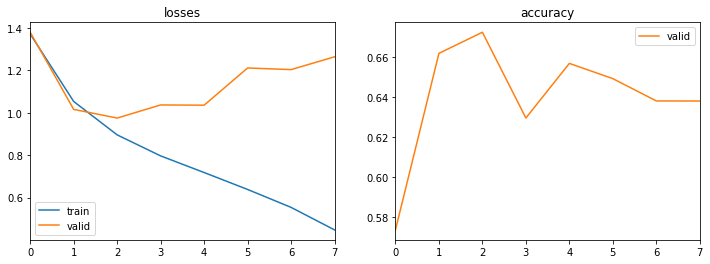

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'lr': 0.01, 'nf': 8, 'optimizer': <function SGD at 0x00000207F9E9D0D8>, 'patience': 5, 'time_steps': 90}
XceptionTime                                                                                                           
 10%|████▌                                         | 3/30 [16:21<3:03:20, 407.41s/trial, best loss: 0.8862910866737366]

epoch,train_loss,valid_loss,accuracy,time
0,1.767912,1.747209,0.338738,00:09
1,1.514740,1.510206,0.559481,00:07
2,1.278250,1.268249,0.594421,00:07
3,1.148902,1.148031,0.636407,00:07
4,1.090262,1.090675,0.652623,00:07
5,1.068115,1.064462,0.656966,00:07
6,1.052217,1.054577,0.656435,00:07
7,1.036201,1.043721,0.657835,00:07
8,1.034844,1.041264,0.657497,00:07
9,1.031973,1.042052,0.657642,00:07


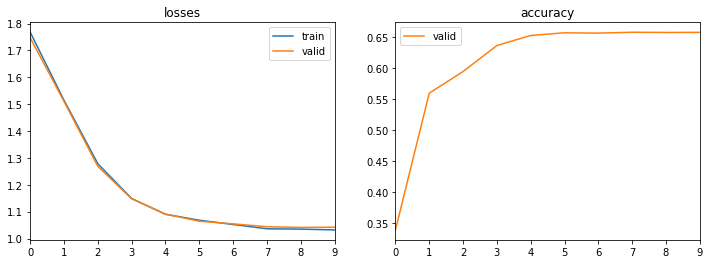

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'lr': 0.01, 'nf': 16, 'optimizer': <function Adam at 0x00000207F9E9D438>, 'patience': 10, 'time_steps': 90}
XceptionTime                                                                                                           
 13%|██████▏                                       | 4/30 [18:07<2:17:09, 316.51s/trial, best loss: 0.8862910866737366]

epoch,train_loss,valid_loss,accuracy,time
0,1.524331,1.486470,0.577675,00:15
1,1.424976,1.440163,0.575937,00:13
2,1.358967,1.335171,0.622267,00:14
3,1.299343,1.282286,0.637228,00:14
4,1.232610,1.231231,0.627672,00:14
5,1.152331,1.135765,0.655953,00:14
6,1.070040,1.127472,0.642054,00:14
7,0.972786,1.077780,0.657883,00:14
8,0.868916,1.020934,0.670721,00:14
9,0.773226,0.934123,0.673182,00:14


No improvement since epoch 9: early stopping                                                                           
 13%|██████▏                                       | 4/30 [23:00<2:17:09, 316.51s/trial, best loss: 0.8862910866737366]

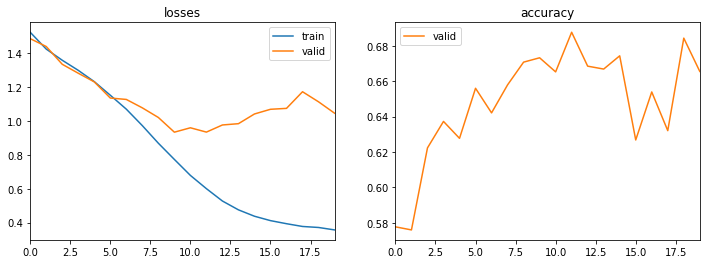

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 50, 'lr': 0.01, 'nf': 16, 'optimizer': <function SGD at 0x00000207F9E9D0D8>, 'patience': 5, 'time_steps': 30}
XceptionTime                                                                                                           
 17%|███████▋                                      | 5/30 [23:28<2:12:28, 317.95s/trial, best loss: 0.8862910866737366]

epoch,train_loss,valid_loss,accuracy,time
0,1.798316,1.812966,0.194392,00:07
1,1.755179,1.784470,0.284253,00:07
2,1.704044,1.745847,0.422373,00:07
3,1.649640,1.691593,0.502968,00:07
4,1.585782,1.623356,0.534578,00:07
5,1.511605,1.540146,0.554413,00:07
6,1.433700,1.450967,0.570484,00:07
7,1.353451,1.364323,0.584190,00:07
8,1.280804,1.283138,0.600261,00:07
9,1.216962,1.218837,0.614063,00:07


No improvement since epoch 40: early stopping                                                                          
 17%|███████▋                                      | 5/30 [29:28<2:12:28, 317.95s/trial, best loss: 0.8862910866737366]

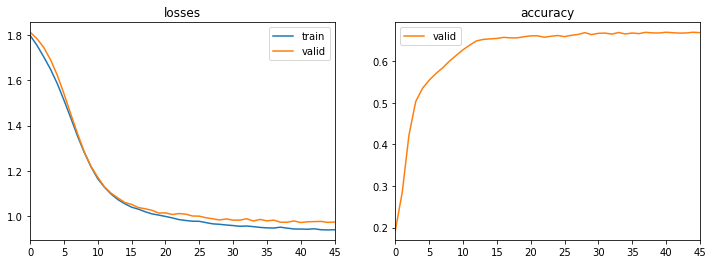

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'lr': 0.01, 'nf': 16, 'optimizer': <function SGD at 0x00000207F9E9D0D8>, 'patience': 10, 'time_steps': 60}
XceptionTime                                                                                                           
 20%|█████████▏                                    | 6/30 [29:56<2:15:33, 338.88s/trial, best loss: 0.8862910866737366]

epoch,train_loss,valid_loss,accuracy,time
0,1.746961,1.743187,0.281598,00:13
1,1.662679,1.679631,0.412239,00:12
2,1.586916,1.609527,0.501231,00:12
3,1.516016,1.556679,0.533324,00:12
4,1.436324,1.475547,0.555523,00:12
5,1.356435,1.386760,0.573283,00:12
6,1.272010,1.310760,0.585734,00:12
7,1.201247,1.235643,0.602384,00:12
8,1.134929,1.176460,0.619082,00:12
9,1.092010,1.111015,0.648666,00:12


No improvement since epoch 30: early stopping                                                                          
 20%|█████████▏                                    | 6/30 [38:39<2:15:33, 338.88s/trial, best loss: 0.8862910866737366]

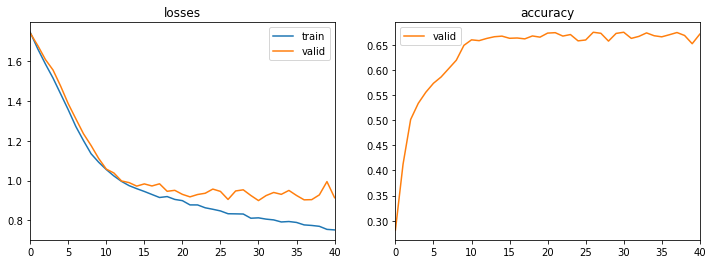

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 10, 'lr': 0.1, 'nf': 32, 'optimizer': <function SGD at 0x00000207F9E9D0D8>, 'patience': 10, 'time_steps': 90}
XceptionTime                                                                                                           
 23%|██████████▋                                   | 7/30 [39:07<2:34:22, 402.73s/trial, best loss: 0.8862910866737366]

epoch,train_loss,valid_loss,accuracy,time
0,1.153829,1.104181,0.654553,00:36
1,0.939267,0.937556,0.679021,00:39
2,0.871378,0.905120,0.679649,00:40
3,0.837606,0.909794,0.672168,00:40
4,0.795585,0.847284,0.688142,00:40
5,0.763406,0.873879,0.677187,00:41
6,0.730069,0.853849,0.688384,00:41
7,0.691621,0.879376,0.678442,00:41
8,0.675141,0.882545,0.681531,00:41
9,0.663413,0.867327,0.687901,00:41


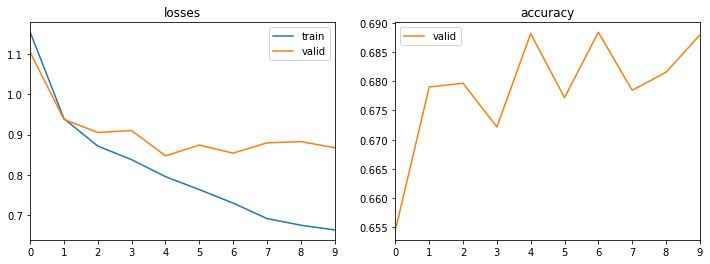

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.001, 'nf': 32, 'optimizer': <function Adam at 0x00000207F9E9D438>, 'patience': 10, 'time_steps': 60}
XceptionTime                                                                                                           
 27%|████████████▌                                  | 8/30 [46:20<2:30:56, 411.66s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,1.572927,1.603685,0.552338,00:28
1,1.507656,1.528627,0.557164,00:29
2,1.467543,1.480089,0.580957,00:29
3,1.433965,1.439154,0.586941,00:30
4,1.406754,1.400313,0.604170,00:30
5,1.377651,1.418669,0.580136,00:30
6,1.348309,1.385904,0.593552,00:30
7,1.315838,1.317573,0.617200,00:30
8,1.275698,1.333997,0.592008,00:30
9,1.230759,1.286022,0.617393,00:30


No improvement since epoch 23: early stopping                                                                          
 27%|████████████                                 | 8/30 [1:03:43<2:30:56, 411.66s/trial, best loss: 0.867327094078064]

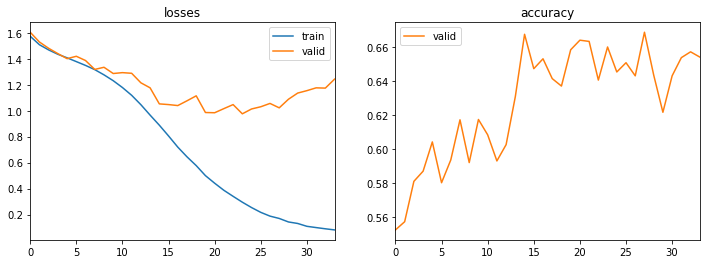

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'lr': 0.1, 'nf': 8, 'optimizer': <function RMSProp at 0x00000207F9E9D1F8>, 'patience': 5, 'time_steps': 60}
XceptionTime                                                                                                           
 30%|█████████████▌                               | 9/30 [1:04:11<3:33:19, 609.51s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,1.174618,0.998961,0.661599,00:06
1,1.045066,1.062714,0.663288,00:05
2,0.990649,0.939746,0.648183,00:05
3,0.967346,0.929292,0.659862,00:05
4,0.956585,0.920889,0.675595,00:05
5,0.947481,0.910130,0.672168,00:05
6,0.931442,0.877313,0.679649,00:05
7,0.922757,0.868166,0.680469,00:05
8,0.913282,0.875953,0.677574,00:05
9,0.908582,0.868463,0.679745,00:05


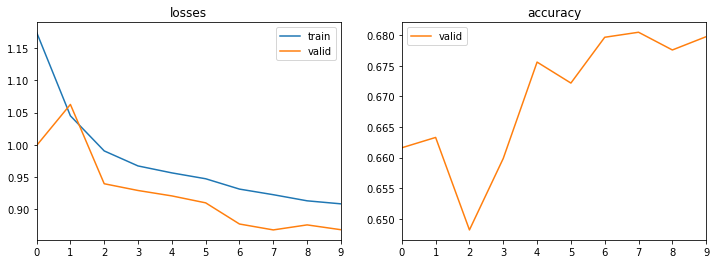

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'lr': 0.0001, 'nf': 8, 'optimizer': <function Adam at 0x00000207F9E9D438>, 'patience': 10, 'time_steps': 90}
XceptionTime                                                                                                           
 33%|██████████████▋                             | 10/30 [1:05:34<2:30:30, 451.52s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,1.717650,1.719531,0.458376,00:07
1,1.591494,1.579385,0.545437,00:07
2,1.523319,1.517563,0.567830,00:07
3,1.478629,1.473340,0.574538,00:07
4,1.449748,1.453810,0.582935,00:07
5,1.427572,1.425756,0.591960,00:07
6,1.413953,1.428741,0.584962,00:07
7,1.406619,1.413384,0.594276,00:07
8,1.402242,1.412439,0.591091,00:07
9,1.398471,1.415030,0.591332,00:07


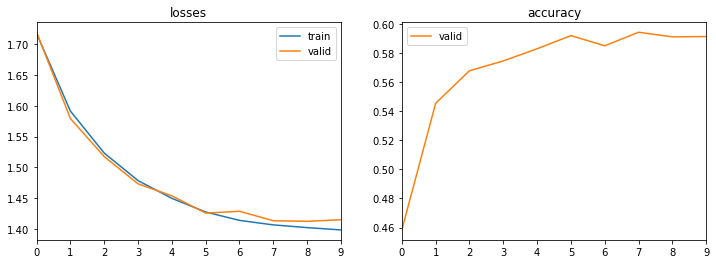

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 50, 'lr': 0.1, 'nf': 16, 'optimizer': <function RMSProp at 0x00000207F9E9D1F8>, 'patience': 5, 'time_steps': 60}
XceptionTime                                                                                                           
 37%|████████████████▏                           | 11/30 [1:07:21<1:50:14, 348.15s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,1.206493,1.157072,0.644515,00:10
1,1.058857,1.040683,0.647025,00:10
2,1.022344,1.155856,0.642392,00:11
3,0.961737,0.950064,0.658462,00:11
4,0.945766,0.942636,0.671734,00:11
5,0.982082,1.252565,0.664543,00:11
6,0.967742,0.972458,0.665219,00:11
7,0.944058,0.954750,0.667535,00:11
8,0.939899,0.906283,0.669948,00:11
9,0.926325,0.901230,0.668452,00:12


No improvement since epoch 9: early stopping                                                                           
 37%|████████████████▏                           | 11/30 [1:10:15<1:50:14, 348.15s/trial, best loss: 0.867327094078064]

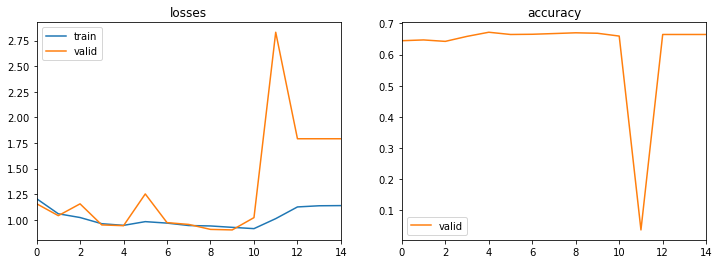

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'lr': 0.01, 'nf': 8, 'optimizer': <function SGD at 0x00000207F9E9D0D8>, 'patience': 5, 'time_steps': 30}
XceptionTime                                                                                                           
 40%|█████████████████▌                          | 12/30 [1:10:43<1:31:18, 304.34s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,1.755945,1.776004,0.346171,00:04
1,1.490814,1.494506,0.555137,00:04
2,1.259562,1.273718,0.595531,00:04
3,1.144128,1.170047,0.627045,00:04
4,1.091019,1.108596,0.651803,00:04
5,1.061424,1.083479,0.657739,00:04
6,1.049538,1.063047,0.660393,00:04
7,1.043844,1.059662,0.660345,00:04
8,1.036508,1.054195,0.660055,00:04
9,1.038677,1.054722,0.659910,00:04


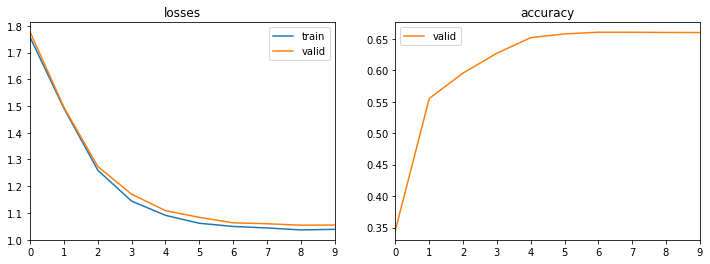

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 50, 'lr': 0.01, 'nf': 16, 'optimizer': <function SGD at 0x00000207F9E9D0D8>, 'patience': 10, 'time_steps': 60}
XceptionTime                                                                                                           
 43%|███████████████████                         | 13/30 [1:11:56<1:06:33, 234.92s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,1.811300,1.815289,0.190290,00:10
1,1.772400,1.780042,0.238743,00:10
2,1.724541,1.727973,0.341586,00:11
3,1.663841,1.671841,0.434873,00:11
4,1.590379,1.589765,0.502292,00:11
5,1.507250,1.503915,0.540707,00:11
6,1.419323,1.419451,0.561604,00:11
7,1.335183,1.341554,0.576324,00:11
8,1.259739,1.259282,0.591815,00:11
9,1.195656,1.199132,0.608224,00:11


No improvement since epoch 32: early stopping                                                                          
 43%|███████████████████                         | 13/30 [1:20:34<1:06:33, 234.92s/trial, best loss: 0.867327094078064]

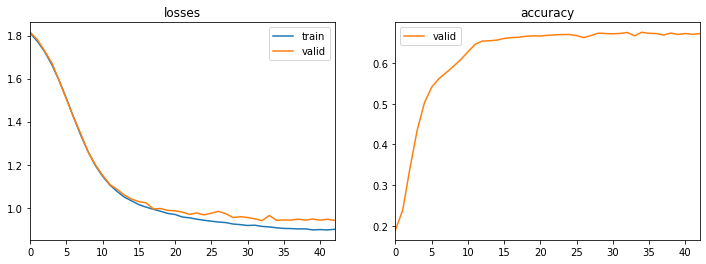

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'lr': 0.001, 'nf': 8, 'optimizer': <function Adam at 0x00000207F9E9D438>, 'patience': 5, 'time_steps': 60}
XceptionTime                                                                                                           
 47%|████████████████████▌                       | 14/30 [1:21:02<1:27:32, 328.28s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,1.650311,1.643764,0.485450,00:06
1,1.565773,1.546932,0.546016,00:06
2,1.493490,1.507474,0.563583,00:05
3,1.425546,1.438553,0.585107,00:06
4,1.372179,1.384211,0.611071,00:06
5,1.313353,1.335764,0.607789,00:06
6,1.253564,1.254118,0.627865,00:06
7,1.185128,1.194326,0.636407,00:06
8,1.118742,1.144097,0.647459,00:06
9,1.047159,1.048122,0.663771,00:06


No improvement since epoch 15: early stopping                                                                          
 47%|████████████████████▌                       | 14/30 [1:23:11<1:27:32, 328.28s/trial, best loss: 0.867327094078064]

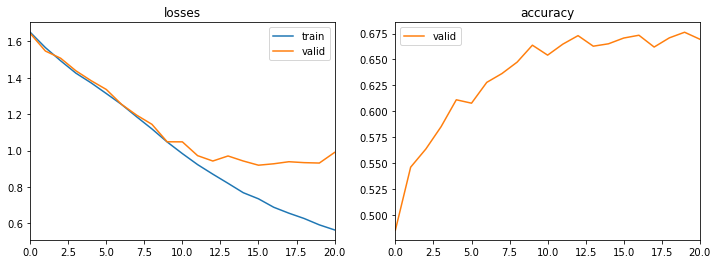

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'lr': 0.0001, 'nf': 8, 'optimizer': <function RMSProp at 0x00000207F9E9D1F8>, 'patience': 10, 'time_steps': 60}
XceptionTime                                                                                                           
 50%|██████████████████████                      | 15/30 [1:23:39<1:09:13, 276.87s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,1.746554,1.767128,0.286087,00:05
1,1.697500,1.727027,0.390039,00:05
2,1.649655,1.685761,0.460161,00:06
3,1.612186,1.646085,0.503113,00:06
4,1.576336,1.604049,0.529897,00:06
5,1.541253,1.555723,0.544037,00:06
6,1.503346,1.511749,0.555572,00:05
7,1.475610,1.481527,0.564210,00:06
8,1.450061,1.468451,0.564596,00:06
9,1.428720,1.450546,0.571305,00:06


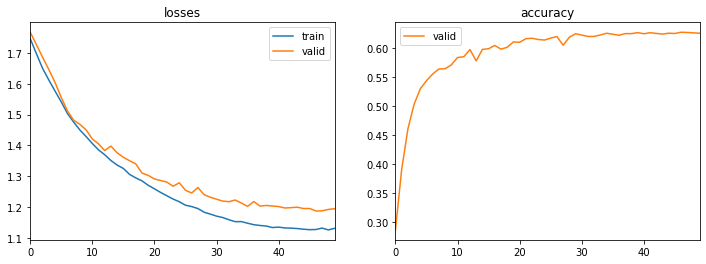

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'lr': 0.1, 'nf': 8, 'optimizer': <function SGD at 0x00000207F9E9D0D8>, 'patience': 5, 'time_steps': 30}
XceptionTime                                                                                                           
 53%|███████████████████████▍                    | 16/30 [1:29:11<1:08:27, 293.41s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,1.384592,1.272021,0.597606,00:04
1,1.033158,1.028378,0.651465,00:04
2,0.974604,0.981133,0.669852,00:04
3,0.948324,0.956862,0.669997,00:04
4,0.935109,0.963959,0.654650,00:04
5,0.914281,0.938896,0.671831,00:04
6,0.901137,0.935636,0.669369,00:04
7,0.892148,0.952412,0.665412,00:04
8,0.882110,0.945122,0.666811,00:04
9,0.874841,0.945836,0.666522,00:04


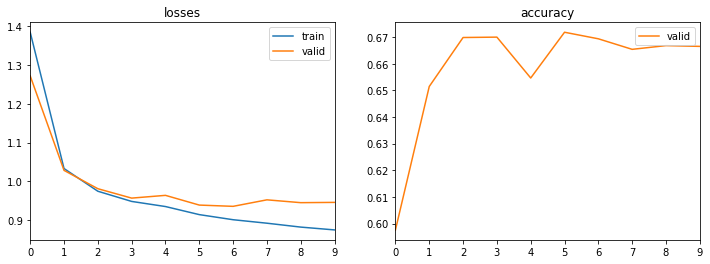

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'lr': 0.01, 'nf': 32, 'optimizer': <function Adam at 0x00000207F9E9D438>, 'patience': 5, 'time_steps': 60}
XceptionTime                                                                                                           
 57%|██████████████████████████                    | 17/30 [1:30:24<49:15, 227.34s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,1.419151,1.409528,0.600405,00:26
1,1.319913,1.273244,0.630230,00:29
2,1.185675,1.184160,0.629410,00:29
3,1.020375,1.170169,0.613870,00:29
4,0.832471,1.026769,0.657980,00:30
5,0.679103,0.999022,0.655663,00:30
6,0.585893,1.123828,0.643984,00:30
7,0.538727,1.200091,0.651754,00:30
8,0.499014,1.080234,0.649148,00:30
9,0.468914,1.115189,0.621592,00:31


No improvement since epoch 5: early stopping                                                                           
 57%|██████████████████████████                    | 17/30 [1:35:53<49:15, 227.34s/trial, best loss: 0.867327094078064]

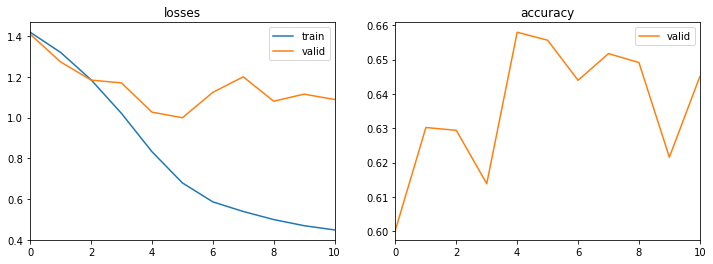

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'lr': 0.001, 'nf': 16, 'optimizer': <function SGD at 0x00000207F9E9D0D8>, 'patience': 10, 'time_steps': 90}
XceptionTime                                                                                                           
 60%|███████████████████████████▌                  | 18/30 [1:36:22<53:14, 266.23s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,1.820602,1.803499,0.177453,00:15
1,1.801363,1.785946,0.202210,00:16
2,1.779364,1.774653,0.215048,00:16
3,1.759838,1.754525,0.272863,00:17
4,1.735297,1.735456,0.344337,00:17
5,1.713589,1.711146,0.400029,00:17
6,1.681713,1.684755,0.440954,00:17
7,1.653799,1.649214,0.486077,00:17
8,1.617442,1.622306,0.508421,00:17
9,1.584302,1.581793,0.529463,00:17


No improvement since epoch 86: early stopping                                                                          
 60%|███████████████████████████▌                  | 18/30 [2:05:41<53:14, 266.23s/trial, best loss: 0.867327094078064]

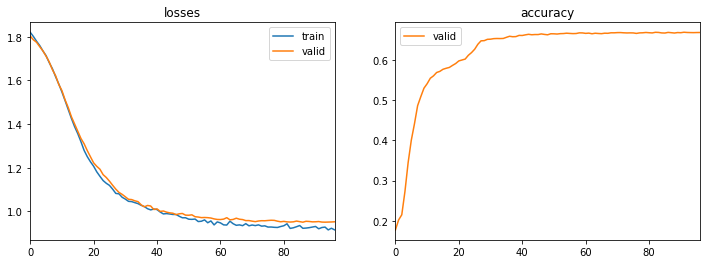

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'lr': 0.1, 'nf': 16, 'optimizer': <function Adam at 0x00000207F9E9D438>, 'patience': 10, 'time_steps': 30}
XceptionTime                                                                                                           
 63%|███████████████████████████▊                | 19/30 [2:06:09<2:12:32, 722.93s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,1.336533,1.296497,0.591091,00:07
1,1.154945,1.066065,0.653250,00:07
2,1.016015,0.987638,0.659138,00:07
3,0.911452,1.011012,0.630713,00:08
4,0.833581,0.989165,0.661648,00:08
5,0.789674,1.019566,0.637373,00:08
6,0.760368,1.178864,0.655663,00:08
7,0.747110,1.036083,0.642585,00:08
8,0.738504,1.087851,0.640268,00:08
9,0.747174,1.196861,0.582839,00:08


No improvement since epoch 2: early stopping                                                                           
 63%|███████████████████████████▊                | 19/30 [2:07:58<2:12:32, 722.93s/trial, best loss: 0.867327094078064]

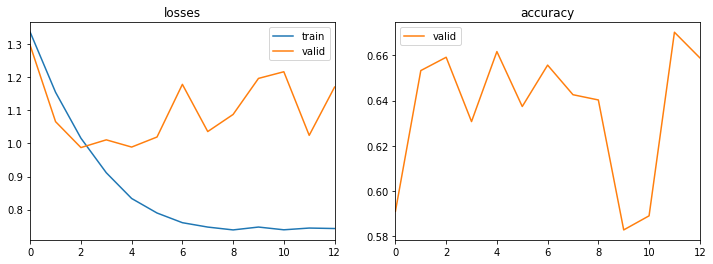

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 10, 'lr': 0.1, 'nf': 32, 'optimizer': <function RMSProp at 0x00000207F9E9D1F8>, 'patience': 10, 'time_steps': 90}
XceptionTime                                                                                                           
 67%|█████████████████████████████▎              | 20/30 [2:08:25<1:31:09, 546.96s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,0.977713,0.962260,0.656098,00:37
1,0.943380,0.910549,0.664688,00:41
2,1.139513,52041124.000000,0.664543,00:39
3,1.137053,46229572.000000,0.048598,00:39
4,1.137579,226566304.000000,0.664543,00:39
5,1.140785,170625856.000000,0.137879,00:39
6,1.137205,26361290.000000,0.137879,00:39
7,1.140145,81729176.000000,0.036678,00:39
8,1.145174,49718944.000000,0.048598,00:39
9,1.138911,2929.966797,0.080884,00:39


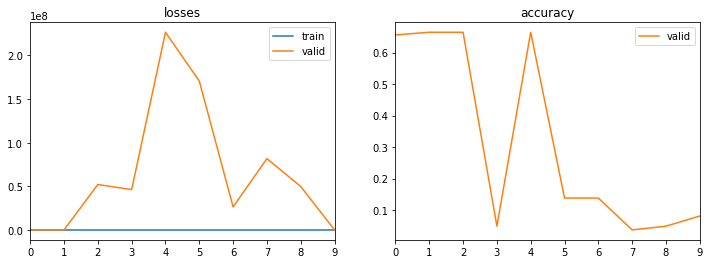

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 10, 'lr': 0.1, 'nf': 32, 'optimizer': <function RMSProp at 0x00000207F9E9D1F8>, 'patience': 5, 'time_steps': 90}
XceptionTime                                                                                                           
 70%|██████████████████████████████▊             | 21/30 [2:15:31<1:16:32, 510.31s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,0.972281,1.077536,0.659476,00:38
1,1.138014,1.791762,0.664543,00:40
2,1.151590,1.791762,0.664543,00:39
3,1.142006,9462157.000000,0.137879,00:39
4,1.140828,1.791762,0.664543,00:39
5,1.130437,29361722.000000,0.048598,00:39


No improvement since epoch 0: early stopping                                                                           
 70%|██████████████████████████████▊             | 21/30 [2:19:29<1:16:32, 510.31s/trial, best loss: 0.867327094078064]

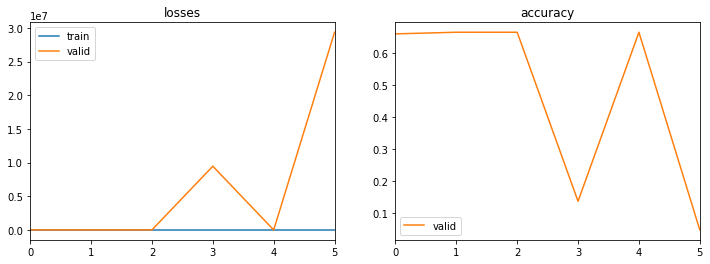

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'lr': 0.1, 'nf': 32, 'optimizer': <function RMSProp at 0x00000207F9E9D1F8>, 'patience': 10, 'time_steps': 90}
XceptionTime                                                                                                           
 73%|█████████████████████████████████▋            | 22/30 [2:19:57<58:17, 437.17s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,1.171333,1.028928,0.664543,00:35
1,1.027776,0.916309,0.664929,00:37
2,0.988487,1.045298,0.653636,00:38
3,0.968862,0.921184,0.651899,00:38
4,0.957772,0.934804,0.655084,00:39
5,0.948541,0.958714,0.658221,00:39
6,0.929411,0.970300,0.646156,00:39
7,0.910079,0.957508,0.652189,00:39
8,0.888685,0.936773,0.643791,00:39
9,0.883662,0.934115,0.653540,00:39


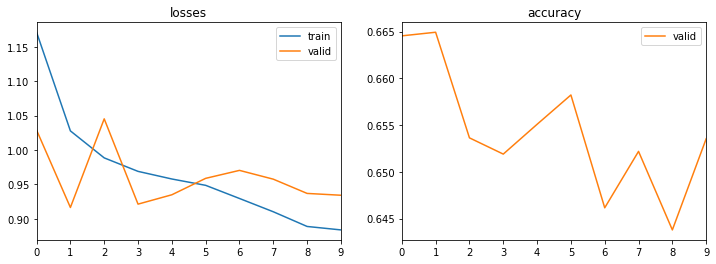

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'lr': 0.1, 'nf': 32, 'optimizer': <function RMSProp at 0x00000207F9E9D1F8>, 'patience': 5, 'time_steps': 60}
XceptionTime                                                                                                           
 77%|███████████████████████████████████▎          | 23/30 [2:26:52<50:13, 430.51s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,1.164607,1.057105,0.664543,00:26
1,1.029533,0.949379,0.656049,00:28
2,1.003227,0.931598,0.649534,00:28
3,0.966989,0.937086,0.659090,00:29
4,0.953205,0.926092,0.658269,00:29
5,0.933830,0.960695,0.612133,00:29
6,0.913562,0.916531,0.657980,00:29
7,0.886793,0.853749,0.679938,00:29
8,0.868537,0.869625,0.675402,00:29
9,0.863394,0.873091,0.676126,00:29


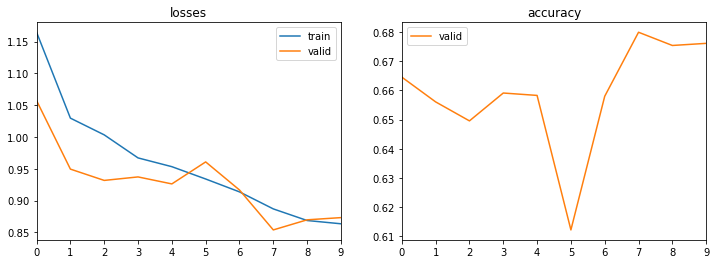

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 10, 'lr': 0.1, 'nf': 8, 'optimizer': <function SGD at 0x00000207F9E9D0D8>, 'patience': 10, 'time_steps': 60}
XceptionTime                                                                                                           
 80%|████████████████████████████████████▊         | 24/30 [2:32:11<39:41, 396.97s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,1.173629,1.096786,0.650258,00:08
1,0.969735,0.953994,0.667053,00:07
2,0.903558,0.904548,0.670238,00:07
3,0.869003,0.922943,0.668066,00:07
4,0.853893,0.862331,0.684378,00:07
5,0.824710,0.898953,0.676898,00:07
6,0.800587,0.902884,0.664736,00:07
7,0.789481,0.887233,0.675981,00:07
8,0.782680,0.891801,0.675981,00:07
9,0.761851,0.893550,0.675740,00:07


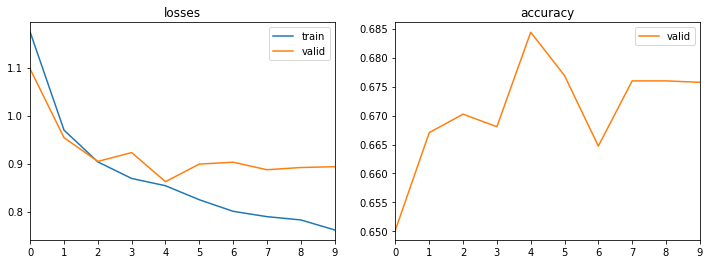

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'lr': 0.1, 'nf': 32, 'optimizer': <function RMSProp at 0x00000207F9E9D1F8>, 'patience': 5, 'time_steps': 90}
XceptionTime                                                                                                           
 83%|██████████████████████████████████████▎       | 25/30 [2:33:58<25:50, 310.08s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,1.156088,0.972335,0.652333,00:34
1,1.025918,0.981537,0.646687,00:37
2,0.986736,1.000928,0.653781,00:38
3,0.946945,0.887149,0.667053,00:39
4,1.090695,106.888702,0.048598,00:38
5,1.140193,6344359.000000,0.048598,00:38
6,1.144798,12369277.000000,0.048598,00:38
7,1.144052,4375953.000000,0.048598,00:37
8,1.144699,1222263.875000,0.048598,00:37


No improvement since epoch 3: early stopping                                                                           
 83%|██████████████████████████████████████▎       | 25/30 [2:39:39<25:50, 310.08s/trial, best loss: 0.867327094078064]

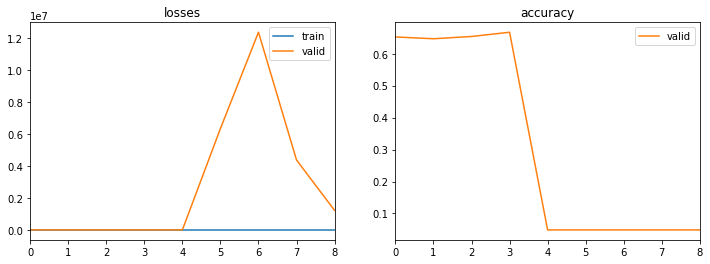

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 10, 'lr': 0.1, 'nf': 32, 'optimizer': <function SGD at 0x00000207F9E9D0D8>, 'patience': 5, 'time_steps': 60}
XceptionTime                                                                                                           
 87%|███████████████████████████████████████▊      | 26/30 [2:40:07<21:50, 327.69s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,1.139687,1.166440,0.628734,00:28
1,0.952277,0.944257,0.665605,00:31
2,0.901635,0.942255,0.665412,00:32
3,0.864773,0.946898,0.666039,00:32
4,0.823764,0.903806,0.656146,00:32
5,0.798231,0.917324,0.664205,00:33
6,0.757458,0.888942,0.674195,00:33
7,0.730511,0.903467,0.664833,00:33
8,0.702736,0.902145,0.668983,00:33
9,0.692314,0.885679,0.675498,00:33


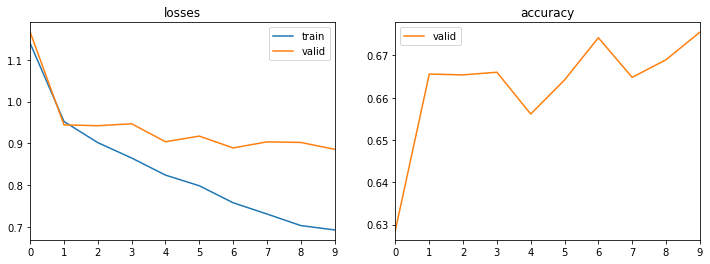

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 10, 'lr': 0.1, 'nf': 8, 'optimizer': <function RMSProp at 0x00000207F9E9D1F8>, 'patience': 10, 'time_steps': 90}
XceptionTime                                                                                                           
 90%|█████████████████████████████████████████▍    | 27/30 [2:46:00<16:45, 335.27s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,0.980736,0.925276,0.660393,00:09
1,0.925026,0.937766,0.637131,00:09
2,0.909165,0.934054,0.646204,00:09
3,1.139128,1.791762,0.664543,00:09
4,1.136055,181269168.000000,0.137879,00:09
5,1.144704,15247367.000000,0.664543,00:09
6,1.137196,2270322.000000,0.080884,00:09
7,1.146839,1.791762,0.664543,00:09
8,1.137974,4046425.250000,0.664543,00:09
9,1.146844,2689.622803,0.664543,00:09


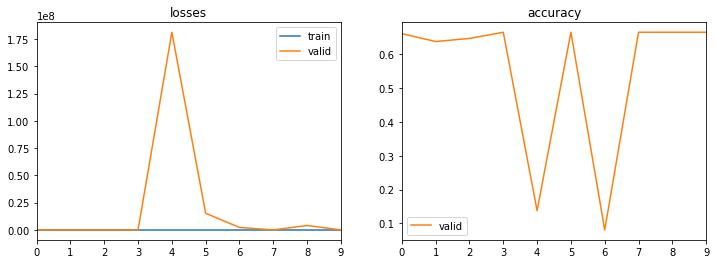

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'lr': 0.0001, 'nf': 8, 'optimizer': <function RMSProp at 0x00000207F9E9D1F8>, 'patience': 10, 'time_steps': 90}
XceptionTime                                                                                                           
 93%|██████████████████████████████████████████▉   | 28/30 [2:48:02<09:02, 271.39s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,1.742337,1.785789,0.474688,00:07
1,1.628545,1.663921,0.562232,00:06
2,1.563091,1.585600,0.567540,00:07
3,1.523573,1.551291,0.570339,00:07
4,1.496014,1.528035,0.566865,00:07
5,1.474984,1.499761,0.572704,00:07
6,1.465055,1.492058,0.577192,00:07
7,1.456225,1.484410,0.579412,00:07
8,1.453884,1.482745,0.578350,00:07
9,1.453380,1.483046,0.579219,00:07


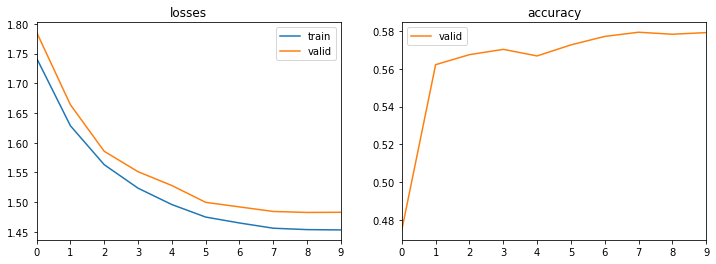

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 10, 'lr': 0.001, 'nf': 32, 'optimizer': <function SGD at 0x00000207F9E9D0D8>, 'patience': 5, 'time_steps': 60}
XceptionTime                                                                                                           
 97%|████████████████████████████████████████████▍ | 29/30 [2:49:47<03:40, 220.41s/trial, best loss: 0.867327094078064]

epoch,train_loss,valid_loss,accuracy,time
0,1.767744,1.802722,0.322378,00:27
1,1.646060,1.714285,0.513392,00:30
2,1.556055,1.636006,0.551180,00:31
3,1.488739,1.567163,0.565417,00:32
4,1.439560,1.520811,0.570822,00:32
5,1.404752,1.494453,0.573042,00:32
6,1.385917,1.455846,0.577434,00:32
7,1.365724,1.464471,0.575696,00:33
8,1.365465,1.436116,0.580184,00:33
9,1.359315,1.452459,0.577434,00:33


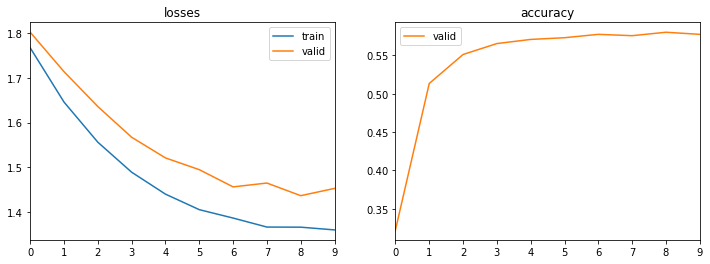

100%|██████████████████████████████████████████████| 30/30 [2:55:06<00:00, 350.20s/trial, best loss: 0.867327094078064]


In [34]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,  # test trials
    trials=trials)

In [35]:
print(best)

{'bs': 0, 'epochs': 0, 'lr': 0, 'nf': 2, 'optimizer': 1, 'patience': 1, 'ts': 2}


In [36]:
from hyperopt import space_eval

In [37]:
print("Best parameters:")
print(space_eval(search_space, best))

Best parameters:
{'batch_size': 256, 'epochs': 10, 'lr': 0.1, 'nf': 32, 'optimizer': <function SGD at 0x00000207F9E9D0D8>, 'patience': 10, 'time_steps': 90}


In [38]:
best_parameters = space_eval(search_space, best)

In [39]:
def build_model(params):
    # clear memory 
    gc.collect()
    print("Trying params:",params)
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    
    # Create data loader
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
    # set num_workers for memory bottleneck
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
    # Create model
    arch = XceptionTime
    k = {
        'nf': params['nf']
    }
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    
    # Training the model
    learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
    start = time.time()
    learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                        cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
    learn.plot_metrics()
    elapsed = time.time() - start
    
    # delete tmp variables
    del dls
    del model
    return learn

Trying params: {'batch_size': 256, 'epochs': 10, 'lr': 0.1, 'nf': 32, 'optimizer': <function SGD at 0x00000207F9E9D0D8>, 'patience': 10, 'time_steps': 90}
XceptionTime


epoch,train_loss,valid_loss,accuracy,time
0,1.144856,1.146309,0.621640,00:37
1,0.948147,1.054391,0.633512,00:41
2,0.887809,0.870433,0.681338,00:42
3,0.835480,0.863290,0.683316,00:42
4,0.807709,0.969354,0.650789,00:42
5,0.767618,0.890422,0.682013,00:42
6,0.739928,0.913959,0.669900,00:42
7,0.698706,0.879975,0.682062,00:43
8,0.670980,0.857197,0.687322,00:43
9,0.652485,0.861043,0.684764,00:43


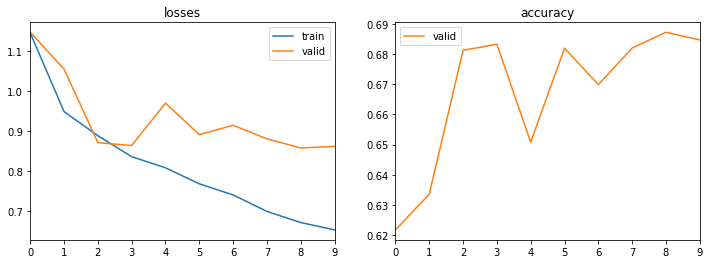

In [40]:
learn = build_model(best_parameters)

In [41]:
dls = learn.dls
valid_dl = dls.valid

In [42]:
time_steps = best_parameters["time_steps"]
X_test_tmp = X_test[:, :, -time_steps:]

In [43]:
test_ds = valid_dl.dataset.add_test(X_test_tmp, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

102430


In [44]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(TensorBase([[4.4839e-01, 3.7145e-01, 9.2907e-02, 5.9969e-02, 1.5612e-02, 1.1675e-02],
         [9.5121e-01, 3.2586e-02, 7.9561e-03, 3.0103e-03, 2.6881e-03, 2.5461e-03],
         [9.7324e-01, 1.2757e-02, 4.4481e-03, 4.4849e-03, 2.4461e-03, 2.6197e-03],
         ...,
         [9.7498e-01, 8.9089e-03, 5.0908e-03, 4.4955e-03, 3.4047e-03, 3.1159e-03],
         [9.9336e-01, 4.0500e-03, 1.1322e-03, 6.1176e-04, 4.3836e-04, 4.0321e-04],
         [8.9602e-01, 6.1524e-02, 1.8148e-02, 1.2354e-02, 6.9453e-03, 5.0113e-03]]),
 TensorCategory([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32),
 TensorBase([0, 0, 0,  ..., 0, 0, 0]))

In [45]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
print(f'f1 score: {skm.f1_score(test_targets, test_preds, average="weighted"):10.6f}')

accuracy:   0.725178
f1 score:   0.702581


Save the true and predicted results:

In [46]:
y_test_true = test_targets.numpy()
y_test_pred = test_preds.numpy()

In [47]:
np.save('y_true_XceptionTime', y_test_true)
np.save('y_pred_XceptionTime', y_test_pred)